In [1]:
import os
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [2]:
dir_train='/kaggle/input/100-bird-species/train/'
dir_test='/kaggle/input/100-bird-species/test/'
dir_valid='/kaggle/input/100-bird-species/valid/'
df=pd.read_csv('/kaggle/input/100-bird-species/birds.csv') #データセット全体
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [3]:
len(df['class id'].unique()) #クラス数

525

In [4]:
df['data set'].value_counts() #各データセットの数

data set
train    84635
test      2625
valid     2625
Name: count, dtype: int64

In [5]:
df["labels"].value_counts() #各ラベルの数

labels
RUFOUS TREPE               273
HOUSE FINCH                258
D-ARNAUDS BARBET           243
OVENBIRD                   243
ASIAN GREEN BEE EATER      230
                          ... 
NORTHERN RED BISHOP        140
SNOWY PLOVER               140
PATAGONIAN SIERRA FINCH    140
EURASIAN GOLDEN ORIOLE     140
RED TAILED THRUSH          140
Name: count, Length: 525, dtype: int64

In [6]:
#訓練データの拡張
transform=T.Compose([ 
    T.Resize((128,128)), #画像サイズを変換
    T.RandomHorizontalFlip(), #ランダムに左右反転
    T.RandomVerticalFlip(), #ランダムに上下反転
    T.ToTensor() #テンソル変換
])

#テストデータの変換
trans_valid=T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

#画像データセットの作成
train_ds=torchvision.datasets.ImageFolder(root=dir_train,transform=transform)
valid_ds=torchvision.datasets.ImageFolder(root=dir_valid,transform=trans_valid)

In [7]:
len(train_ds.classes) #訓練データセットのクラス数

525

In [8]:
#ミニバッチの作成
train_dl=DataLoader(train_ds, batch_size=64, num_workers=2 ,shuffle=True)
valid_dl=DataLoader(valid_ds, batch_size=64, num_workers=2 ,shuffle=True)

In [9]:
#画像を表示する関数
def show_images(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.imshow(make_grid(images[:32],nrow=8).permute(1,2,0)) #permuteで次元を[チャネル][高さ][幅]から[高さ][幅][チャネル]に変換しないと表示できない
        break

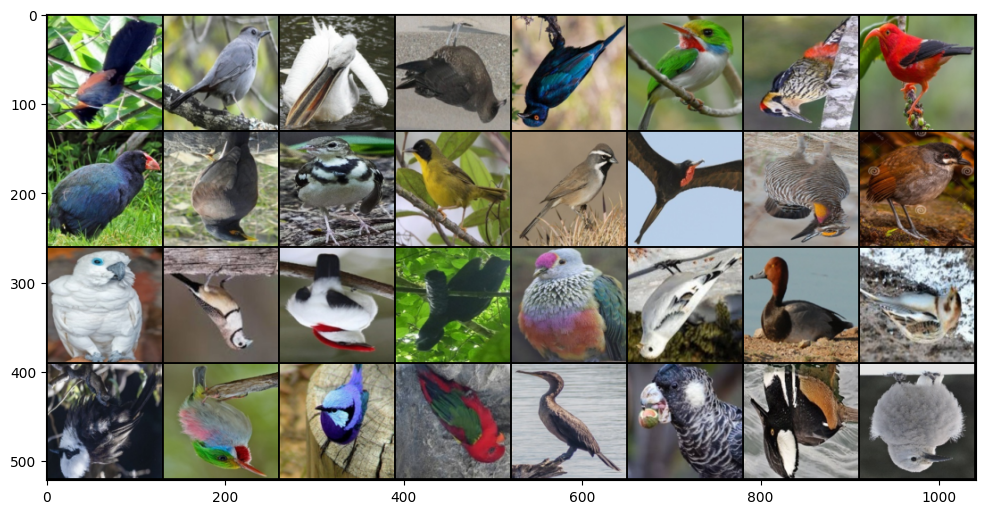

In [10]:
show_images(train_dl)

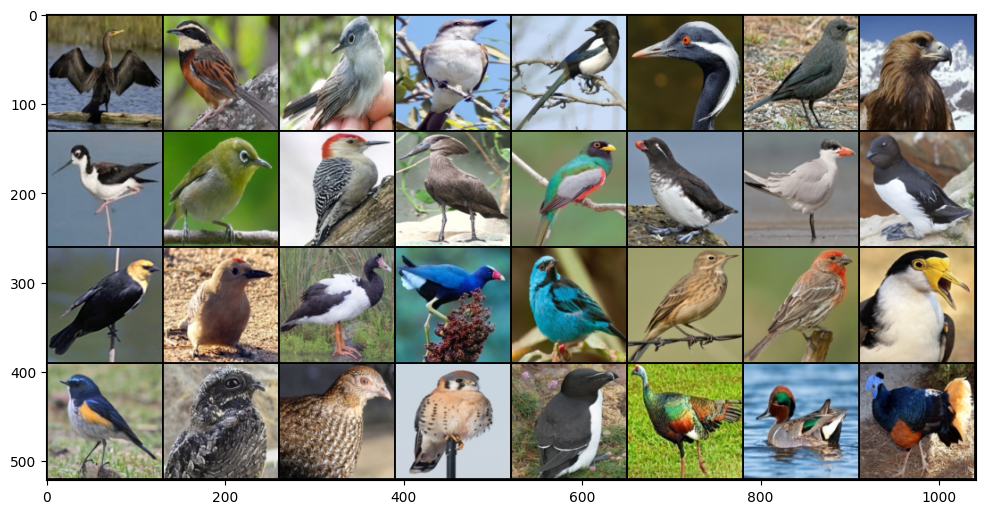

In [11]:
show_images(valid_dl)

In [12]:
model=models.vgg16(pretrained=True) #訓練済みvggモデル
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache() #GPUキャッシュの削除
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
print(model.classifier[6]) #モデルの最後のレイヤー

Linear(in_features=4096, out_features=1000, bias=True)


In [14]:
#ファインチューニング
num_f=model.classifier[6].in_features #モデルの最後のレイヤーの入力特徴量の数
model.classifier[6]=nn.Linear(num_f,525) #出力数をクラス数に書き換えてレイヤーを置き換え
model.to(device)
print(model.classifier[6]) 

Linear(in_features=4096, out_features=525, bias=True)


In [15]:
epochs=10
train_steps = len(train_dl)
valid_steps = len(valid_dl)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
metrics={'loss':[],'val_loss':[],'val_acc':[]} #各指標の数字を格納
for epoch in range(epochs):
    train_loss=[]
    valid_loss=[]
    model.train() #訓練モード
    for batch in train_dl: #各ミニバッチを取り出す
        optimizer.zero_grad()
        images,labels=batch #画像とそのラベル
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward() #逆伝播
        optimizer.step() #パラメータ更新
        train_loss.append(loss.data.item()) #ミニバッチごとの訓練誤差を格納
        if len(train_loss)%100==0: #訓練誤差が100回計算されるごとに
            print('Epoch:',epoch+1)
            print('train_loss:',train_loss[-1]) #最新の訓練誤差
            
    model.eval() #推論モード
    num_correct=0 #正解数
    num_sample=0 #サンプル数
    for batch in valid_dl:
        optimizer.zero_grad()
        images,labels=batch
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = criterion(pred, labels)
        valid_loss.append(loss.data.item()) 
        values, indices = torch.max(pred.data, axis=1) #各ラベルに所属する確率の中で一番高い数値とそのラベル
        num_correct+=(indices==labels).sum().item() #予測の正解数 torch.Tensorの要素をitem関数でintにしている
        num_sample+=labels.size(0) #size(0)でサンプル数
        if len(valid_loss)%20==0:
            print('Epoch:',epoch+1)
            print('valid_loss:',valid_loss[-1])
    accuracy=num_correct / num_sample #正解数/全てのサンプル数
    train_loss_mean=torch.mean(torch.Tensor(train_loss)).item() #epochごとに算出された訓練誤差の平均
    valid_loss_mean=torch.mean(torch.Tensor(valid_loss)).item() #epochごとに算出された汎化誤差の平均
    metrics["loss"].append(train_loss_mean)
    metrics["val_loss"].append(valid_loss_mean)
    metrics["val_acc"].append(accuracy)
    print('training_loss:',train_loss_mean, 'validation_loss:', valid_loss_mean, 'accuracy:',accuracy)

Epoch: 1
train_loss: 6.191434383392334
Epoch: 1
train_loss: 5.688408374786377
Epoch: 1
train_loss: 4.584799289703369
Epoch: 1
train_loss: 3.4553704261779785
Epoch: 1
train_loss: 2.733480453491211
Epoch: 1
train_loss: 2.8228046894073486
Epoch: 1
train_loss: 2.7463107109069824
Epoch: 1
train_loss: 1.977743148803711
Epoch: 1
train_loss: 1.838948130607605
Epoch: 1
train_loss: 1.440689206123352
Epoch: 1
train_loss: 1.6274783611297607
Epoch: 1
train_loss: 1.376083493232727
Epoch: 1
train_loss: 0.9106640219688416
Epoch: 1
valid_loss: 1.0259150266647339
Epoch: 1
valid_loss: 0.9853423833847046
training_loss: 3.1733837127685547 validation_loss: 0.9083326458930969 accuracy: 0.7493333333333333
Epoch: 2
train_loss: 0.968085527420044
Epoch: 2
train_loss: 1.1510629653930664
Epoch: 2
train_loss: 1.2255446910858154
Epoch: 2
train_loss: 1.0048632621765137
Epoch: 2
train_loss: 1.3322830200195312
Epoch: 2
train_loss: 1.0688409805297852
Epoch: 2
train_loss: 0.9240632653236389
Epoch: 2
train_loss: 1.2494953

<Axes: >

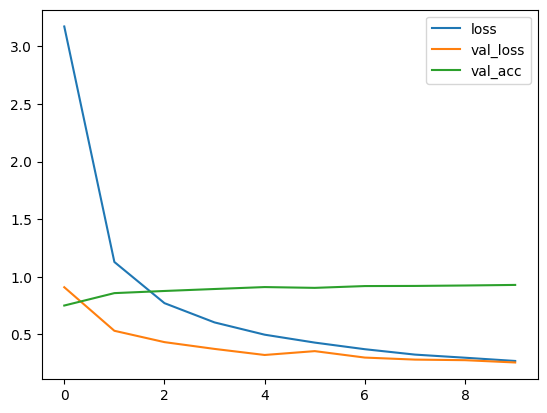

In [16]:
pd.DataFrame(metrics).plot() #metricsに格納した３つの指標をプロット